In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install visdom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408196 sha256=71b9b204ecb202e47e7b01f85a166b7d1be69f9721c8356d3c15c87112460515
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built visdom


In [4]:
import os

tj_dir = "/content/drive/MyDrive/colab_notebooks_shared"
wh_dir = "/content/drive/MyDrive/Colab Notebooks"
ella_dir = "/content/drive/MyDrive/Colab Notebooks"

working_dir = wh_dir

os.chdir(working_dir)


# Demo Pipeline

In [5]:
import network
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image
import numpy as np
import matplotlib
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection

from datasets import VOCSegmentation
import utils
from utils import ext_transforms as et


In [63]:
ckpt = f"{working_dir}/checkpoints/stop sign best/mask_rcnn_coco_50epochs.pth"
img = "vandalized.jpg"
# img = "img.jpg"
# img = "partially_destroyed.jpg"
# img = "blurred.jpg"
img_path = f"{working_dir}/" + img
# img_path = f"{working_dir}/results/33_image.png"

In [12]:
# Init model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    in_features_mask, hidden_layer, num_classes
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 184MB/s]


In [13]:
# Loading checkpoint
model.load_state_dict(torch.load(ckpt))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Model restored from %s" % ckpt)

<ipython-input-13-6429b71df2e2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt))


Model restored from /content/drive/MyDrive/Colab Notebooks/checkpoints/stop sign best/mask_rcnn_coco_50epochs.pth


In [64]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = Image.open(img_path)
img_tensor = transform(image)
print(img_tensor.shape)

torch.Size([3, 440, 660])


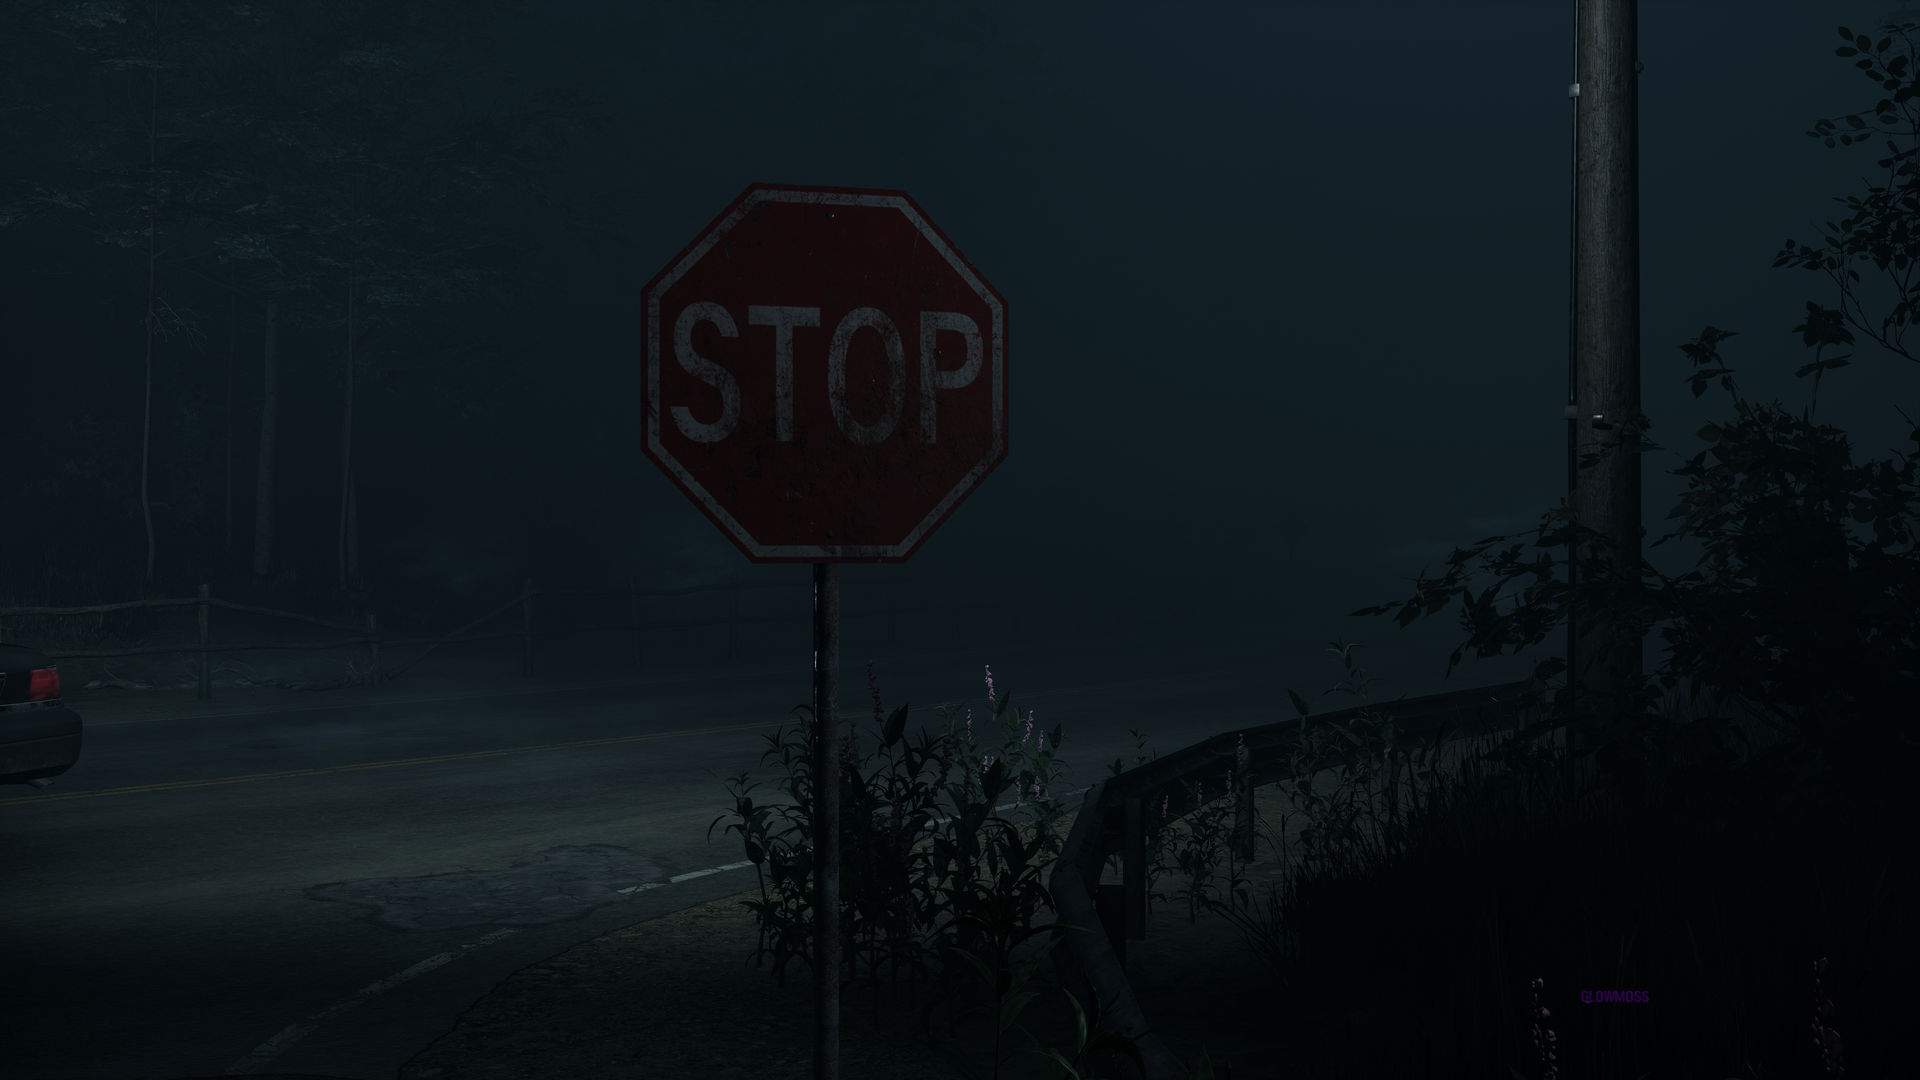

In [ ]:
image

In [65]:
model.eval()
img_tensor = img_tensor.to(device)
output = model(img_tensor.unsqueeze(0))

In [66]:
masks = output[0]['masks'].detach().cpu().numpy()
scores = output[0]['scores'].detach().cpu().numpy()

In [67]:
score_threshold = 0.5
valid_indices = np.where(scores > score_threshold)[0]

Bounding box rows: 23 to 429
Bounding box columns: 124 to 564


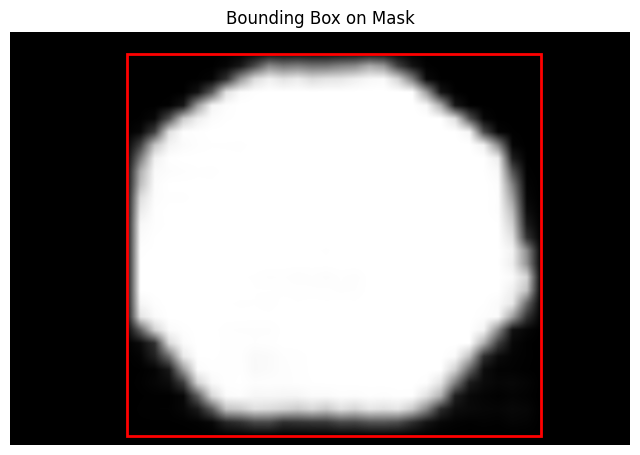

In [68]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

mask_vis = None
if valid_indices.size > 0:
    best_index = valid_indices[0]
    pred_mask = masks[best_index][0]
    mask_vis = pred_mask

    rows_with_true = np.where(np.any(pred_mask, axis=1))[0]
    cols_with_true = np.where(np.any(pred_mask, axis=0))[0]

    if rows_with_true.size > 0 and cols_with_true.size > 0:
        min_row, max_row = rows_with_true[0], rows_with_true[-1]
        min_col, max_col = cols_with_true[0], cols_with_true[-1]
    else:
        min_row = max_row = min_col = max_col = None
    print(f"Bounding box rows: {min_row} to {max_row}")
    print(f"Bounding box columns: {min_col} to {max_col}")
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(pred_mask, cmap="gray") 

    if min_row is not None and min_col is not None:
        rect = Rectangle((min_col, min_row), max_col - min_col + 1, max_row - min_row + 1,
                         linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.title("Bounding Box on Mask")
    plt.axis("off")
    plt.show()

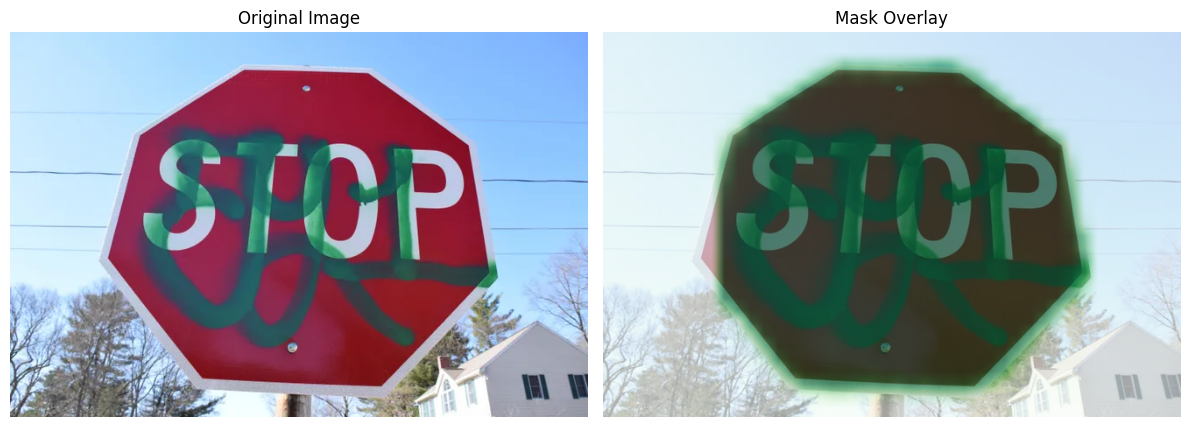

In [69]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(image) 
axes[1].imshow(mask_vis, cmap='Greens', alpha=0.6)  
axes[1].set_title("Mask Overlay")
axes[1].axis("off")

if min_row is not None and min_col is not None:
    rect = Rectangle(
        (min_col, min_row),
        max_col - min_col + 1,
        max_row - min_row + 1,
        linewidth=2,
        edgecolor='blue',
        facecolor='none'
    )

plt.tight_layout()
plt.show()


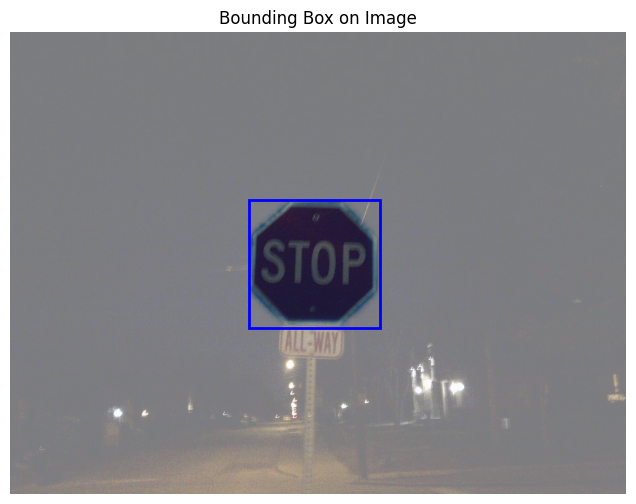

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image)  
ax.imshow(mask_vis, cmap='Blues', alpha=0.5) 
if min_row is not None and min_col is not None:
    rect = Rectangle((min_col, min_row), max_col - min_col + 1, max_row - min_row + 1,
                     linewidth=2, edgecolor='blue', facecolor='none')

    ax.add_patch(rect)

plt.title("Bounding Box on Image")
plt.axis("off")
plt.show()

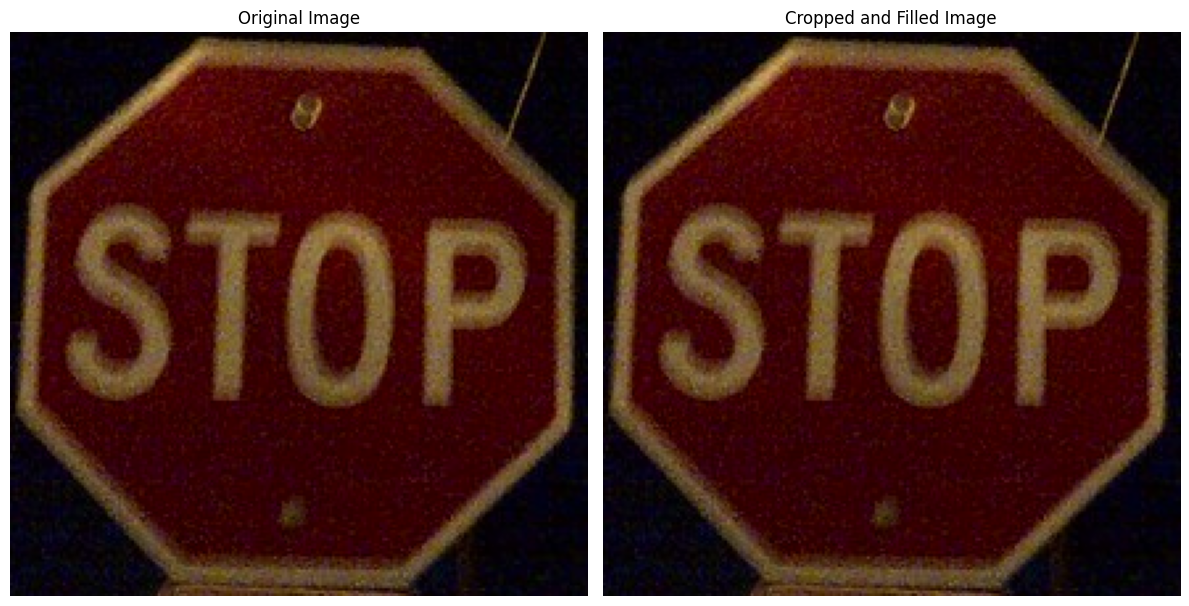

In [ ]:
image_np = np.array(image)
cropped_image = image_np[min_row:max_row+1, min_col:max_col+1]
cropped_mask = mask_vis[min_row:max_row+1, min_col:max_col+1]

non_mask_indices = cropped_mask == 0

filled_image = cropped_image.copy()
padded_image = np.pad(
    cropped_image,
    pad_width=((1, 1), (1, 1), (0, 0)), 
    mode='edge'
)
for i in range(filled_image.shape[0]):
    for j in range(filled_image.shape[1]):
        if non_mask_indices[i, j]:
            filled_image[i, j] = cropped_image[0,0] 

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cropped_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(filled_image)
axes[1].set_title("Cropped and Filled Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,223 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
import pytesseract
from PIL import Image
import cv2
import numpy as np


In [ ]:
img = cv2.cvtColor(filled_image, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
count_white = np.sum(binary_image > 0)
count_black = np.sum(binary_image == 0)
if count_black > count_white:
    binary_image = 255 - binary_image

# # Apply erosion
# binary_image = cv2.erode(binary_image, kernel, iterations=2)

(-0.5, 218.5, 213.5, -0.5)

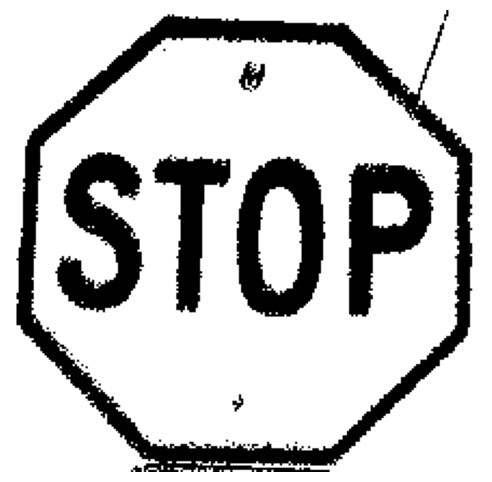

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(binary_image,cmap="gray")
ax.axis("off")

In [ ]:
results = pytesseract.image_to_string(binary_image, config='--psm 6')

print("Text detected:")
print(results)

Text detected:



In [ ]:
lines = results.splitlines()
header = lines[0]
data = lines[1:]

detected_text = []
for line in data:
    cols = line.split('\t')
    if len(cols) == 12:
        text = cols[-1]
        conf = cols[-2]
        if text.strip():
            detected_text.append(text)

h, w = binary_image.shape 
processed_image = binary_image.copy()
boxes = pytesseract.image_to_boxes(processed_image,  config='--psm 6')

for b in boxes.splitlines():
    b = b.split(" ")
    processed_image = cv2.rectangle(processed_image,
                            (int(b[1]), h-int(b[2])),
                            (int(b[3]), h-int(b[4])),
                            (0, 255, 0),
                            2)
cv2.imwrite("processed_imgs/output_with_letter_boxes.png", processed_image)


word_image = binary_image.copy()
data = pytesseract.image_to_data(word_image, config='--psm 6', output_type=pytesseract.Output.DICT)
n_boxes = len(data['text'])
for i in range(n_boxes):
    word = data['text'][i].strip()
    if word and (int(float(data['conf'][i])) > 0) and len(word) > 2:
        print(f"Word detected is: {word}")
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        print(x, y, w, h)
        offset = 80
        cv2.rectangle(word_image, (x, y + offset), (x + w, y + h - offset), (255, 255, 255), 2)
        cv2.putText(word_image, word, (x, y+offset -10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

cv2.imwrite("processed_imgs/output_with_word_boxes.png", word_image)

True

(-0.5, 218.5, 213.5, -0.5)

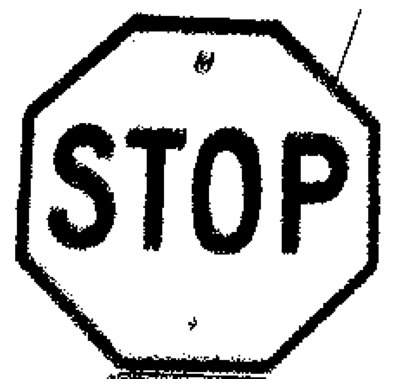

In [ ]:
plt.imshow(word_image, cmap="gray")
plt.axis("off")

# THANK YOU FOR WATCHING OUR DEMO!